# Ultralytics YOLO

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import torch.nn as nn

In [ ]:
model = YOLO('yolov8n.pt')
model.model

In [ ]:
model.info()

# YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
# (129, 3157200, 0, 8.8575488)

# YOLO From Scratch

In YOLO (You Only Look Once), the model is typically broken into three major parts:

- **Backbone**

  Purpose: Feature extraction from input images.

  - The backbone is the first stage of the model.

  - It takes the input image and passes it through a series of convolutional layers.

  - The goal is to extract rich spatial features like edges, textures, shapes, and patterns.

  In simple terms: The backbone is like the “eyes” of the model — it looks at the image and extracts meaningful information.

- **Neck**

  Purpose: Aggregates and enhances the features for different scales.

  - The neck connects the backbone and the head.

  - It helps the model detect objects at different scales (small, medium, large).

  - Passes richer information to the head for final predictions.

  In simple terms: The neck mixes the features from the backbone so the head can make better decisions — like combining different clues before solving a puzzle.

- **Head**

  Purpose: Final predictions – object classification and bounding box regression.

  - The head outputs:

    - Bounding box coordinates

    - Objectness score

    - Class probabilities
    
  In simple terms: The head is the “brain” — it takes the processed features and decides what is in the image, where it is, and how confident it is.

**YOLO Architect**

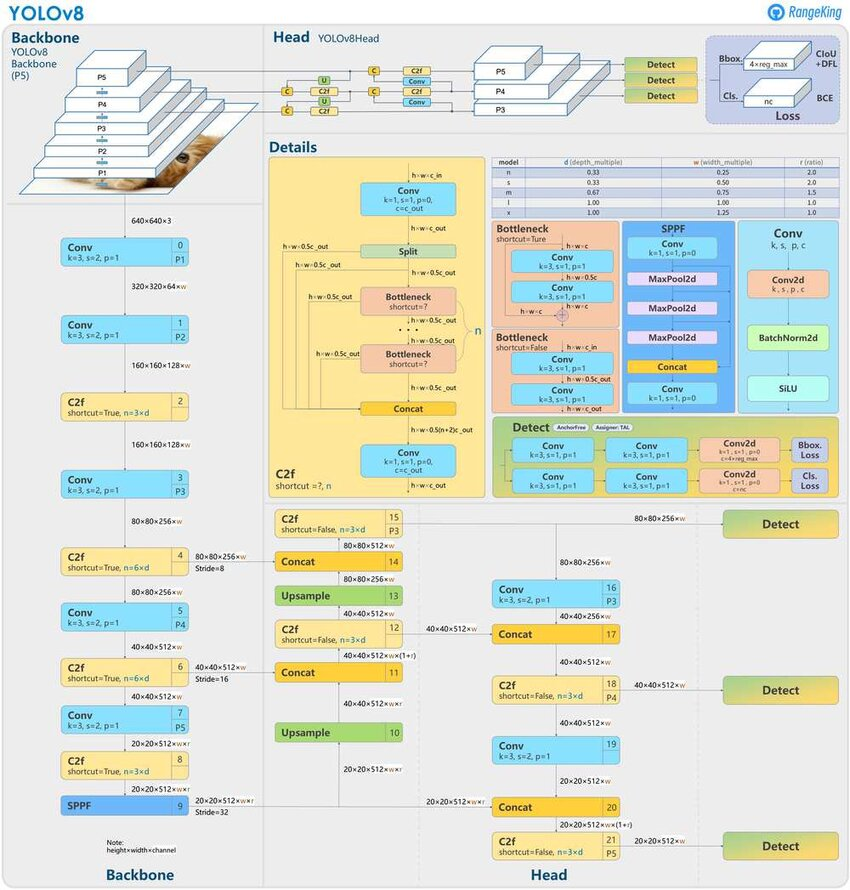

# Backbone Blocks


- Conv

  Structure: `Conv2d + BatchNorm2d + SiLU`

  - Used for downsampling and feature transformation.

  - BatchNorm

    - Faster convergence

      - Allows using larger learning rates safely

      - Gradients are more stable across layers.
    
    - Less sensitivity to weight initialization

    - Acts like regularization

      - Helps generalization by adding noise (from batch statistics).

      - Can reduce or replace dropout in many cases.
  
  - SiLU

    - SiLU (x) = x ⋅ sigmoid (x)

    - Unlike ReLU (which kills negative values), SiLU lets small negative signals through — this improves gradient flow but it's slightly slower.

- C2f (Cross-Stage Partial Bottleneck with 2 Convolutions)

  Structure: `Conv + Bottlenecks + Conv`

  - A lightweight residual block that improves feature reuse and efficiency.
  - Allows deeper networks with fewer parameters and less computational cost.
  
                Input
                  │
              Conv (1x1)
                  │
         ┌────────┴────────┐
         │                 │
        Bottleneck x N    Shortcut
         │                 │
         └────┬──────┬─────┘
              │      │
        Concat (channel-wise)
                  │
              Conv (1x1)
                  ↓
                Output

  - Problem: Deep networks like ResNet stack many layers, but:

    - They become heavy

    - Features may be lost or over-smoothed

  - Solution: C2f split features:

    - One part goes through bottlenecks (deep learning)

    - One part skips them (retains original info)

    - Then merge (concat) them

    - This keeps useful signals while allowing deep learning on a subset of features → fast and accurate.

- SPPF (Spatial Pyramid Pooling – Fast)

  Structure: `Conv + MaxPool2d (with different kernel sizes) + Conv`

  - It’s a feature enhancement block used at the end of the backbone to improve multi-scale representation before passing to the neck and head.
  - Applies multiple pooling operations at different scales to capture multi-scale contextual information.
  - Outputs a fixed-size feature map, regardless of input size.
  - MaxPooling Helps YOLO capture multi-scale spatial context without reducing resolution
  - Why do we need it?
    - Convolutional layers are local — they only see a small patch.
    - But object detection requires global context (to know what’s going on in different scales of the image).

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, groups=1, eps=0.001, momentum=0.03):
    super().__init__()

    self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False, groups=groups),  # because the bias is usually unnecessary when using BatchNorm.
                nn.BatchNorm2d(out_channels, eps=eps,momentum=momentum),
                nn.SiLU()
                )

  def forward(self, x):
      return self.conv(x)

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, channels, shortcut=True):
        super().__init__()
        self.conv1 = Conv(channels, channels)
        self.conv2 = Conv(channels, channels)
        self.shortcut = shortcut

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        return x + y if self.shortcut else y  # residual connection

class C2f(nn.Module):
  def __init__(self, in_channels, out_channels, num_bottlenecks=2):
    super().__init__()

    hidden_channels = out_channels // 2  # split

    # First Conv
    self.conv1 = Conv(in_channels, hidden_channels, kernel_size=1, stride=1, padding=0)
    # sequence of bottleneck layers
    self.blocks = nn.ModuleList([Bottleneck(hidden_channels) for _ in range(num_bottlenecks)])
    # Last Conv
    self.conv2 = Conv(hidden_channels * (num_bottlenecks + 1), out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
        x = self.conv1(x)

        outputs = [x]

        for block in self.blocks:
            x = block(x)
            outputs.append(x)

        x = torch.cat(outputs, dim=1)  # concat along channel dimension

        return self.conv2(x)

In [ ]:
# sanity check
c2f=C2f(in_channels=64, out_channels=128, num_bottlenecks=2)
print(f"{sum(p.numel() for p in c2f.parameters())/1e6} million parameters")

dummy_input=torch.rand((1,64,244,244))
dummy_input=c2f(dummy_input)
print("Output shape: ", dummy_input.shape)  # torch.Size([1, 128, 244, 244])

In [ ]:
class SPPF(nn.Module):
    def __init__(self, in_channels, out_channels, pool_kernel=5):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels, kernel_size=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=1, padding=pool_kernel // 2)
        self.conv2 = Conv(out_channels * 4, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.conv1(x)  # x sees local details
        y1 = self.pool(x)  # y1 sees more context (5×5)
        y2 = self.pool(y1)  # y2 sees even more (~9×9)
        y3 = self.pool(y2)  # y3 sees global (~13×13)
        concat = torch.cat([x, y1, y2, y3], dim=1)  # All are concatenated along channel axis to give the model a rich, multi-scale feature map.
        return self.conv2(concat)

In [ ]:
# sanity check
sppf=SPPF(in_channels=128,out_channels=512)
print(f"{sum(p.numel() for p in sppf.parameters())/1e6} million parameters")

dummy_input=sppf(dummy_input)
print("Output shape: ", dummy_input.shape)  # torch.Size([1, 512, 244, 244])

# Backbone Architecture

Backbone will store intermediate feature maps at 3 scales:

- out1: Low-level features (small receptive field, high resolution)

- out2: Mid-level features

- out3: High-level features (large receptive field, low resolution)

These 3 are used in the Neck for fusion.





**YOLOv8 Backbone — Summary of Channel Sizes**

| **Layer**   | **Operation** | **Output Channels** | **Purpose**                    |
|:----------:|:-------------:|:-------------------:|:------------------------------:|
| conv_0     | Conv          | 64 × w              | Stem convolution (↓ 1/2)       |
| conv_1     | Conv          | 128 × w             | Downsampling (↓ 1/4)           |
| c2f_2      | C2f           | 128 × w             | Local patterns                 |
| conv_3     | Conv          | 256 × w             | Downsampling (↓ 1/8)           |
| c2f_4      | C2f           | 256 × w             | Feature output `out1`          |
| conv_5     | Conv          | 512 × w             | Downsampling (↓ 1/16)          |
| c2f_6      | C2f           | 512 × w             | Feature output `out2`          |
| conv_7     | Conv          | 512 × w × r         | Downsampling (↓ 1/32)          |
| c2f_8      | C2f           | 512 × w × r         | Deep features                  |
| sppf       | SPPF          | 512 × w × r         | Multi-scale context → `out3`   |


In [ ]:
# return (depth, width, ratio multipliers) based on version
def yolo_params(version):
    if version=='n':
        return 1/3,1/4,2.0
    elif version=='s':
        return 1/3,1/2,2.0
    elif version=='m':
        return 2/3,3/4,1.5
    elif version=='l':
        return 1.0,1.0,1.0
    elif version=='x':
        return 1.0,1.25,1.0

In [ ]:
class YOLOv8Backbone(nn.Module):
    def __init__(self, version='n', in_channels=3):
        super().__init__()
        d, w, r = yolo_params(version)  # depth, width, ratio multipliers

        # Stage 1 — Stem
        self.conv_0 = Conv(in_channels, int(64 * w), 3, 2)
        self.conv_1 = Conv(int(64 * w), int(128 * w), 3, 2)
        self.c2f_2   = C2f(int(128 * w), int(128 * w), num_bottlenecks=int(3 * d))

        # Stage 2 — Low-level features
        self.conv_3 = Conv(int(128 * w), int(256 * w), 3, 2)
        self.c2f_4   = C2f(int(256 * w), int(256 * w), num_bottlenecks=int(6 * d))

        # Stage 3 — Mid-level features
        self.conv_5 = Conv(int(256 * w), int(512 * w), 3, 2)
        self.c2f_6   = C2f(int(512 * w), int(512 * w), num_bottlenecks=int(6 * d))

        # Stage 4 — Deep features
        self.conv_7 = Conv(int(512 * w), int(512 * w * r), 3, 2)
        self.c2f_8   = C2f(int(512 * w * r), int(512 * w * r), num_bottlenecks=int(3 * d))

        # Final spatial pyramid pooling
        self.sppf = SPPF(int(512 * w * r), int(512 * w * r))

    def forward(self, x):
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.c2f_2(x)

        x = self.conv_3(x)
        out1 = self.c2f_4(x)  # 1/8 scale

        x = self.conv_5(out1)
        out2 = self.c2f_6(x)  # 1/16 scale

        x = self.conv_7(out2)
        x = self.c2f_8(x)
        out3 = self.sppf(x)   # 1/32 scale

        return out1, out2, out3

In [ ]:
# sanity check
x = torch.randn(1, 3, 640, 640)
model = YOLOv8Backbone(version='n')
out1, out2, out3 = model(x)
print(out1.shape, out2.shape, out3.shape)  # torch.Size([1, 64, 80, 80]) torch.Size([1, 128, 40, 40]) torch.Size([1, 256, 20, 20])

# Neck Architecture

In [ ]:
import torch.nn.functional as F

In [ ]:
class YOLOv8Neck(nn.Module):
    def __init__(self, version, ch_in=[64, 128, 256]):
        super().__init__()
        depth, width, _ = yolo_params(version)
        c3, c4, c5 = ch_in  # channels from out1, out2, out3

        # Top-down
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.reduce_conv1 = Conv(c5, c4, 1, 1)
        self.c2f_td1 = C2f(c4 * 2, c4, num_bottlenecks=int(3 * depth))

        self.reduce_conv2 = Conv(c4, c3, 1, 1)
        self.c2f_td2 = C2f(c3 * 2, c3, num_bottlenecks=int(3 * depth))

        # Bottom-up
        self.down_conv1 = Conv(c3, c3, 3, 2)
        self.c2f_bu1 = C2f(c3 + c4, c4, num_bottlenecks=int(3 * depth))

        self.down_conv2 = Conv(c4, c4, 3, 2)
        self.c2f_bu2 = C2f(c4 + c5, c5, num_bottlenecks=int(3 * depth))

    def forward(self, out1, out2, out3):
      # Top-down
      x = self.reduce_conv1(out3)
      x = F.interpolate(x, size=out2.shape[2:], mode='nearest')  # match out2
      x = torch.cat([x, out2], dim=1)
      td1 = self.c2f_td1(x)

      x = self.reduce_conv2(td1)
      x = F.interpolate(x, size=out1.shape[2:], mode='nearest')  # match out1
      p3 = self.c2f_td2(torch.cat([x, out1], dim=1))

      # Bottom-up
      down1 = self.down_conv1(p3)
      p4 = self.c2f_bu1(torch.cat([down1, td1], dim=1))

      down2 = self.down_conv2(p4)
      p5 = self.c2f_bu2(torch.cat([down2, out3], dim=1))

      return p3, p4, p5  # high, mid, low resolution features


In [ ]:
# sanity check
neck = YOLOv8Neck(version='n')
p3, p4, p5 = neck(out1, out2, out3)

print(p3.shape, p4.shape, p5.shape)  # torch.Size([1, 64, 80, 80]) torch.Size([1, 128, 40, 40]) torch.Size([1, 256, 20, 20])

# Head Blocks

High-Level Structure
Takes feature maps from the Neck at 3 scales (P3, P4, P5) and For each scale, predicts:

- 4 box coordinates: (x, y, w, h)

- 1 objectness score

- C class probabilities

Total output per location = C + 5 (for each grid cell)

Output Shape Overview
Given input feature maps:

- P3: [B, C3, 80, 80]

- P4: [B, C4, 40, 40]

- P5: [B, C5, 20, 20]

Output predictions:

- pred3: [B, C+5, 80, 80]

- pred4: [B, C+5, 40, 40]

- pred5: [B, C+5, 20, 20]

Each prediction is a dense grid of predictions, directly regressing box and class scores — no anchors needed.

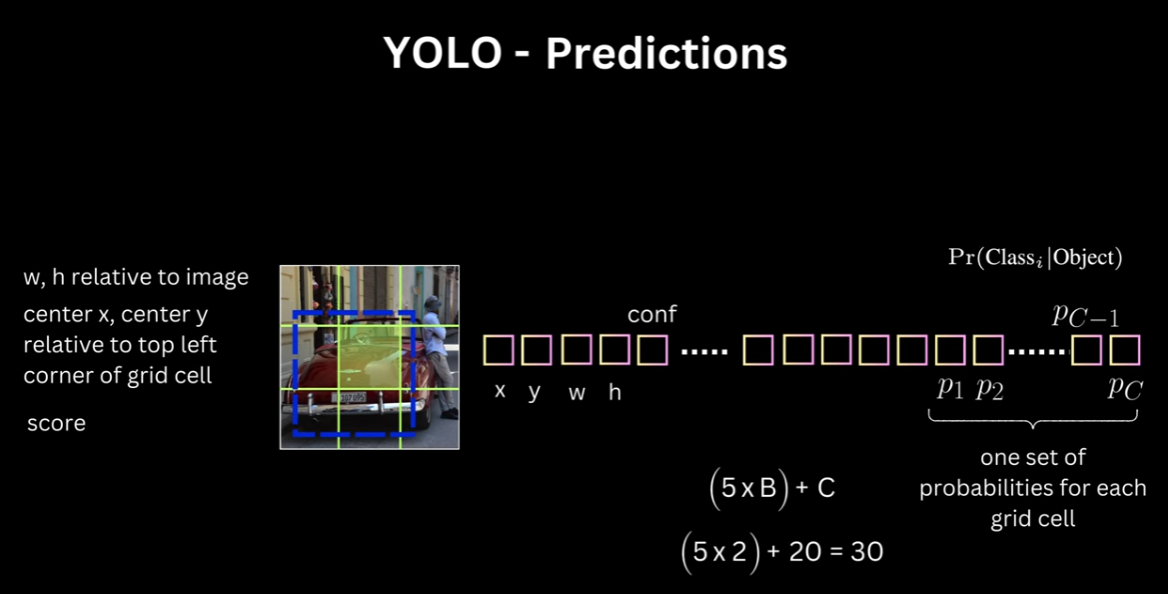

## DFL Projection Module

Converting predicted discrete probability distributions over bins into a continuous box coordinate.

 This is not the loss — it’s just the inference-time transformation to decode the discrete predictions into usable coordinates.

In [ ]:
class DFL(nn.Module):
    def __init__(self, reg_max=16):  # The number of bins = 16 (0 to 15).
        super().__init__()

        self.ch = reg_max
        # Create a 1×1 convolution that maps a bin-wise probability distribution to a scalar
        self.proj = nn.Conv2d(in_channels=reg_max, out_channels=1, kernel_size=1, bias=False).requires_grad_(False)  # freeze weights — we don't train this layer. It just computes an expectation

        # initialize proj with [0, ..., reg_max-1]
        bins = torch.arange(reg_max, dtype=torch.float)  # tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.])
        bins = bins.view(1, reg_max, 1, 1)  # Reshape to match proj weight shape: [out_channels, in_channels, 1, 1]

        # Set bins as the proj’s weight, so when proj is applied to softmaxed distribution, it performs a dot product with bin indices → gives the expected value
        self.proj.weight.data[:]= bins
        self.proj.requires_grad_(False)

    def forward(self, x):  # x: [batch_size, 4*reg_max, total_locations] - Each of the 4 box coordinates (l, t, r, b) has reg_max bins
      # x: [bs, 4*ch, h*w]
      bs, _, n = x.shape

      x = x.view(bs, 4, self.ch, n)  # Reshape to separate 4 box coordinates → [bs, 4, ch, n]
      x = x.transpose(1, 2)  # Transpose → [bs, ch, 4, n] to move bin dimension to channel dim (so softmax applies correctly)

      # Apply softmax over bins for each of the 4 box values (l, t, r, b)
      x = x.softmax(1)  # Result: a distribution over bins for each box side  -  Or we could just apply softmax(2) (no need to transpose)

      # Compute the expected value (continuous coordinate) for each box side
      x = self.proj(x).squeeze(1)  # [bs, 1, 4, n] -> Reshape to [batch_size, 4, num_locations] → continuous l, t, r, b values for each anchor
      return x

In [ ]:
# sanity check
dummy_input = torch.rand((1, 64, 128))
dfl = DFL()
print(f"{sum(p.numel() for p in dfl.parameters())} parameters")

dummy_output=dfl(dummy_input)
print(dummy_output.shape)  # torch.Size([1, 4, 128])

# Head Architecture

3 feature maps (from the Neck) → we create 3 heads (one per level).

Each will have:

- 2 convs for classification features

- 2 convs for regression features

- a classifier (cls_preds)

- a DFL bin predictor (reg_preds)

In [ ]:
class YOLOv8Head(nn.Module):
    def __init__(self, nc=80, reg_max=16):
        """
        ch_in_list: list of input channels from FPN levels
        nc: number of classes
        reg_max: number of bins - 16 (e.g. 0 → 15 bins)
        """
        super().__init__()

        # Store config variables
        self.nc = nc
        self.reg_max = reg_max
        self.stride = torch.tensor([8, 16, 32], dtype=torch.float32)  # How much each feature map cell covers in the original image

        self.cls_convs = nn.ModuleList()
        self.reg_convs = nn.ModuleList()
        self.cls_preds = nn.ModuleList()
        self.reg_preds = nn.ModuleList()

        ch_in_list = [64, 128, 256]

        for ch_in in ch_in_list:
            self.cls_convs.append(
                nn.Sequential(Conv(ch_in, ch_in), Conv(ch_in, ch_in))
            )
            self.reg_convs.append(
                nn.Sequential(Conv(ch_in, ch_in), Conv(ch_in, ch_in))
            )
            self.cls_preds.append(nn.Conv2d(ch_in, nc, 1))
            self.reg_preds.append(nn.Conv2d(ch_in, 4 * self.reg_max, 1))

        self.proj = DFL(self.reg_max)

    # Training & Inference
    def forward(self, feats, training=False):  # feats = list of FPN features at different scales.

        bs = feats[0].shape[0]
        cls_outputs, box_outputs = [], []

        # Run Each Feature Map Through the Head
        for i, feat in enumerate(feats):
          cls_feat = self.cls_convs[i](feat)
          reg_feat = self.reg_convs[i](feat)

          cls_pred = self.cls_preds[i](cls_feat)
          reg_pred = self.reg_preds[i](reg_feat)

          cls_outputs.append(cls_pred)
          box_outputs.append(reg_pred)

        # Return raw predictions for loss computation
        if training:
          return cls_outputs, box_outputs

        # Inference Mode
        cls_out = []
        box_out = []

        # Flatten each output from [bs, C, h, w] → [bs, C, h*w] for both class and box.
        for i in range(len(cls_outputs)):
          cls = cls_outputs[i]
          reg = box_outputs[i]

          bs, _, h, w = cls.shape
          cls = cls.view(bs, self.nc, -1)
          reg = reg.view(bs, 4 * self.reg_max, -1)

          reg = self.proj(reg)  # [bs, 4, h*w]

          # Create grid of anchor points
          grid_y, grid_x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
          grid = torch.stack((grid_x, grid_y), dim=-1).view(-1, 2).to(cls.device).float()
          stride = self.stride[i]

          # Decode boxes
          xy = (grid[None] + 0.5) * stride           # [1, num_anchors, 2] - center of anchor in image space
          lt = reg[:, 0:2, :].permute(0, 2, 1)       # [bs, num_anchors, 2]
          rb = reg[:, 2:4, :].permute(0, 2, 1)       # [bs, num_anchors, 2]

          tl = xy - lt * stride                      # [bs, num_anchors, 2]
          br = xy + rb * stride                      # [bs, num_anchors, 2]

          boxes = torch.cat([(tl + br) / 2, br - tl], dim=2)  # [bs, num_anchors, 4]
          boxes = boxes.permute(0, 2, 1)             # [bs, 4, num_anchors] final format


          cls_out.append(cls)
          box_out.append(boxes)

        cls_out = torch.cat(cls_out, dim=2)
        box_out = torch.cat(box_out, dim=2)

        return torch.cat([box_out, cls_out.sigmoid()], dim=1)  # [bs, 4+nc, num_preds]

In [ ]:
# Example input feature maps from neck
x = [torch.rand(1, 64, 80, 80), torch.rand(1, 128, 40, 40), torch.rand(1, 256, 20, 20)]

head = YOLOv8Head()

# Training mode
head.train()
cls_preds, box_preds = head(x, training=True)
print(cls_preds[0].shape, box_preds[0].shape)  # cls_pred: torch.Size([1, 80, 80, 80]) - box_pred: torch.Size([1, 64, 80, 80])

# Inference mode
head.eval()
output = head(x)
print(output.shape)  # torch.Size([1, 84, 8400])


# My Model

In [ ]:
class MyYolov8(nn.Module):
    def __init__(self,version):
        super().__init__()
        self.backbone = YOLOv8Backbone(version=version)
        self.neck = YOLOv8Neck(version=version)
        self.head = YOLOv8Head()

    def forward(self,x):
        x = self.backbone(x)
        x = self.neck(x[0], x[1], x[2])
        return self.head(list(x))

model = MyYolov8(version='n')
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")
print(model)

# Training

## Dataset

**COCO Dataset**

In [ ]:
!mkdir -p coco
%cd coco

# Images
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip

# Annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip
!unzip train2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

In [ ]:
import os
import torch
import torchvision.transforms.functional as F
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from PIL import Image
import random

In [ ]:
class COCODataset(Dataset):
    def __init__(self, root, ann_file, img_size=640, transforms=None):
        self.root = root
        self.coco = COCO(ann_file)
        self.img_ids = list(sorted(self.coco.imgs.keys()))
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert('RGB')

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            cx = x + w / 2
            cy = y + h / 2

            # Normalize
            cx /= img.width
            cy /= img.height
            w /= img.width
            h /= img.height

            boxes.append([cx, cy, w, h])
            labels.append(ann['category_id'] - 1)  # category_id starts at 1

        target = torch.tensor(boxes + [[-1, -1, -1, -1]] * (50 - len(boxes)))[:50]  # (N, 4)
        cls = torch.tensor(labels + [-1] * (50 - len(labels)))[:50]                 # (N,)

        if self.transforms:
            img = self.transforms(img)

        return img, target, cls

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_dataset = COCODataset(
    root='train2017',
    ann_file='annotations/instances_train2017.json',
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
print(f"Train_loader : {len(train_loader)} batches")

## Loss Function

### YOLOv1

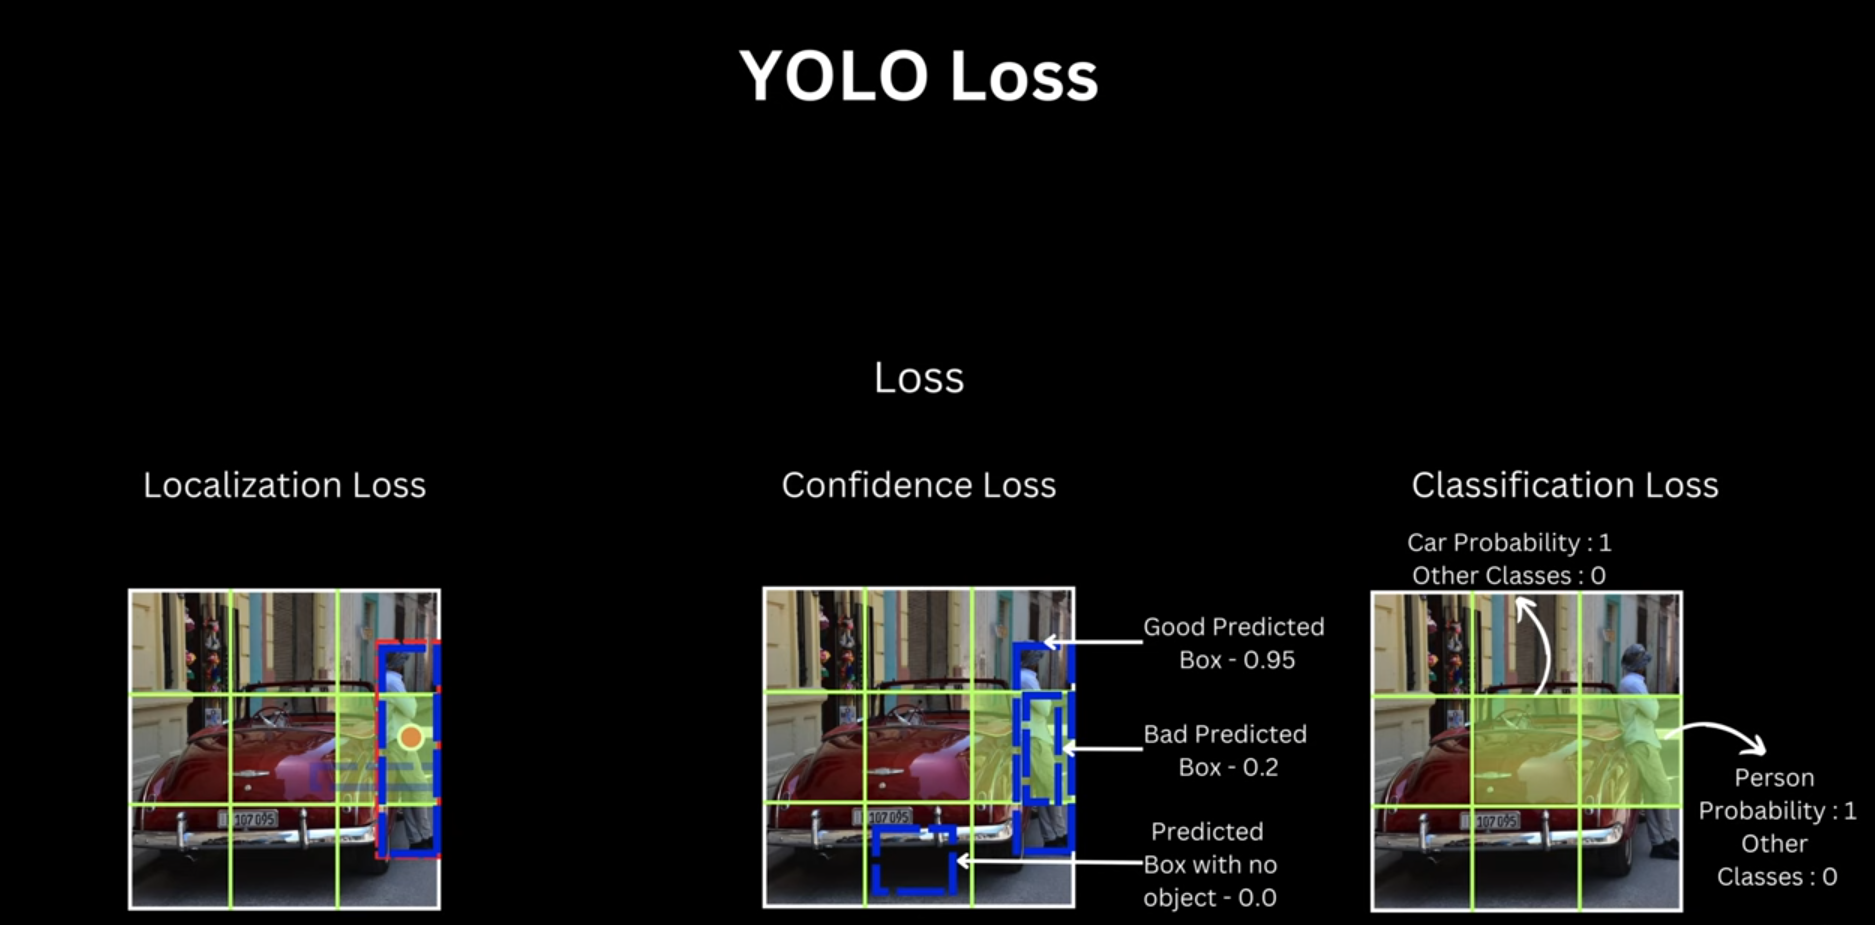


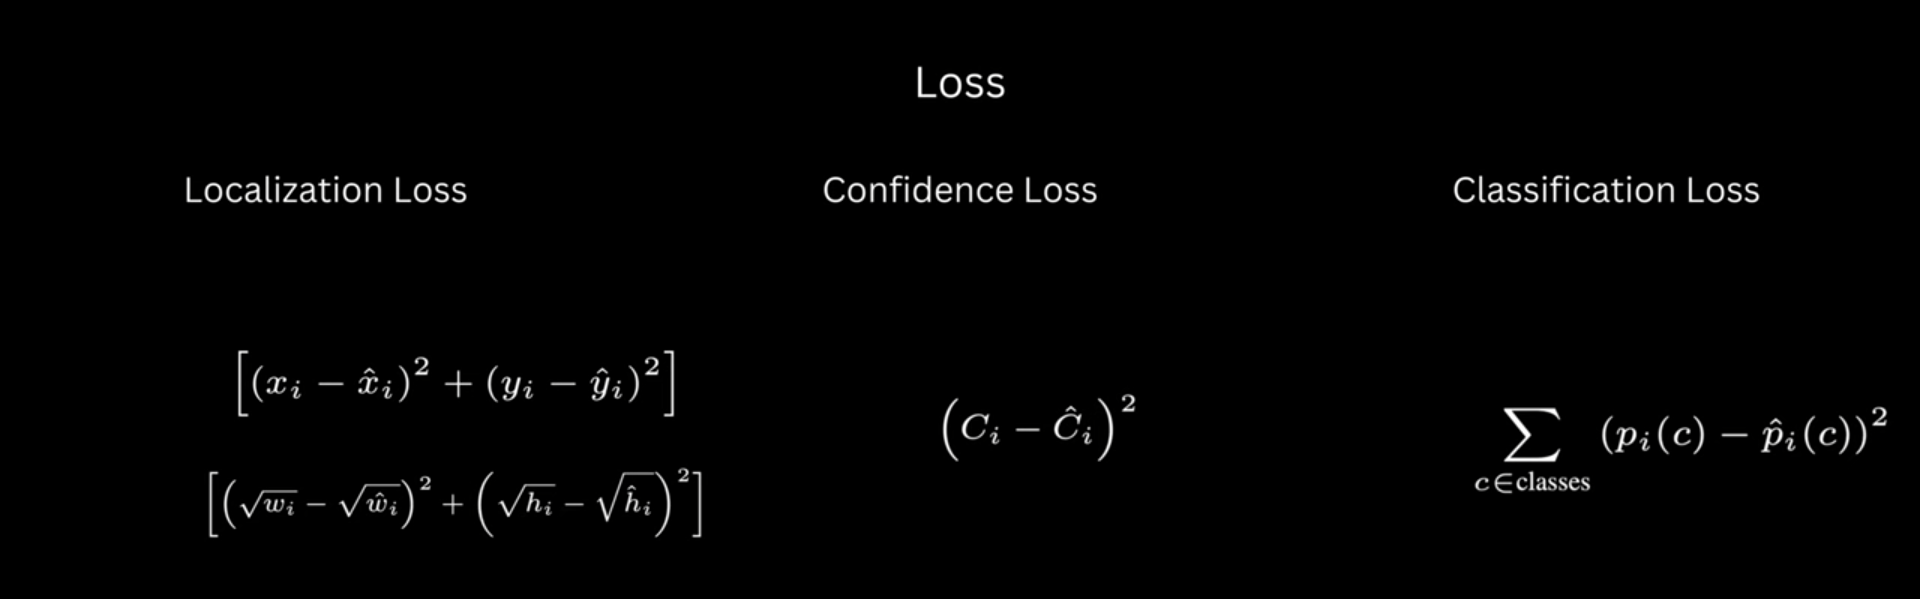

Localization Loss in YOLOv1:

$
\mathcal{L}_{\text{coord}} = \sum_{i=1}^{S^2} \sum_{j=1}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[
(x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2
\right]
$

Where:
- $(x_i, y_i) $: predicted box center
- $(\hat{x}_i, \hat{y}_i) $: ground truth center
- $(w_i, h_i) $: predicted width and height
- $(\hat{w}_i, \hat{h}_i) $: ground truth width and height
- $( \mathbb{1}_{ij}^{\text{obj}} $): indicator if object is present in cell $( i $) and box \( j \) is responsible for prediction

This loss structure penalizes:

- The center coordinate error with standard squared difference

- The width/height error using square root to stabilize gradients when bounding boxes are large

  - Without square root:

    - A small error (e.g. 0.1) in width would penalize large boxes just as much as small boxes.

    - This is unfair because a 0.1 error is more significant for a small box (say, 0.2 wide) than for a large one (say, 0.9 wide).

    - The square root makes the error relative to box size.


### YOLOv8

YOLOv8 incorporates several loss components to fine-tune object detection. These include **Localization Loss**, **Confidence Loss**, **Classification Loss**, and **Distributed Focal Loss (DFL)**.

---
**DFL**

- DFL is a loss function designed to improve object detection accuracy.
- Unlike standard loss functions, DFL focuses on hard-to-detect examples.
It helps the model by assigning more weight to challenging instances, making it easier to learn from them. This focus on complex cases helps the model become more accurate over time.

- DFL boosts performance by distributing the loss function across different object scales and classes.

- Instead of predicting continuous bounding box offsets (like x, y, w, h), DFL predicts a probability distribution over discrete bins for each box side (e.g., left, top, right, bottom).

  -  Example:
    - Let’s say you want to predict a box offset = 7.3

      - You don’t just regress a single number.

      - You do predict a distribution over a range of integer bins (e.g., 0 to 15).

    - DFL teaches the model to put:

      - Most weight on bin 7 (floor)

      - Some weight on bin 8 (ceil)

      - Based on how close 7.3 is to each

    - This gives soft targets, not just hard classes.

| Term         | Meaning                                                                           |
| ------------ | --------------------------------------------------------------------------------- |
| **Bin**      | A discrete class representing a location (e.g., \[0, 1, ..., 16])                 |
| **reg\_max** | Number of bins                                     |
| **DFL**      | Loss over these bins, used to predict continuous values via softmax + expectation |


## Train Loop

In [ ]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and move to device
model = MyYolov8(version='n').to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def dummy_loss(cls_preds, box_preds, targets):
    return torch.tensor(0.0, requires_grad=True).to(device)

num_epochs = 5

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (imgs, targets, classes) in enumerate(train_loader):

        imgs = torch.stack(imgs).to(device)  # shape [batch_size, 3, 640, 640]

        optimizer.zero_grad()

        outputs = model(imgs)

        loss = dummy_loss(None, None, None)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(train_loader):.4f}")


# Extra

**YOLOv8 vs Earlier YOLOs**

| Classic YOLO (v1)          | Modern YOLO (v8)                  |
| -------------------------- | --------------------------------- |
| Hardcoded `S×S` grid       | Grid = shape of feature map       |
| One scale (e.g., 7×7)      | Multi-scale (80×80, 40×40, 20×20) |
| Anchors used (v2–v5)       | Anchor-free (v8)                  |
| Output structured manually | Output via conv layers            |


# Intresting Resources

[YOLOv1](https://www.youtube.com/watch?v=TPD9AfY7AHo&t=502s)

[Groups, Depthwise, and Depthwise-Separable Convolution (Neural Networks)](https://www.youtube.com/watch?v=vVaRhZXovbw)

[Pooling](https://www.youtube.com/watch?v=KKmCnwGzSv8)

# Fun Concepts

- Vanishing & Exploding Gradients

- Receptive Field & Max Pooling

- FPN-Style Pyramid

- Anchor in Object Detection